# CH03.3. **Transposed CNN**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 10
USE_PRETRAIN_YN = 'Y'
MODEL_PTH = '../../model/mnistAutoEncoder.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import ipywidgets
import random
import tqdm
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torchvision
import torchinfo

#(2) Set up options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Set up device
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

#(4) Set up HTML tag
display(ipywidgets.HTML("""<style> .white-play button {background-color:white !important; color:black !important;} </style>"""))

>> Device : mps


HTML(value='<style> .white-play button {background-color:white !important; color:black !important;} </style>')

#### 00.2. **사용자정의함수 정의**

In [ ]:
#(1) Define `show_img()` function
def show_img(df:torchvision.datasets, index:int) -> plt.figure :
    img = df[index][0]
    target = df[index][1]
    img = (img/2+0.5).numpy() # -1 ~ 1 normalization 
    channel_cnt = img.shape[0]
    if channel_cnt == 3 :
        img = np.transpose(a=img, axes=(1, 2, 0))
        plt.imshow(X=img) 
    elif channel_cnt == 1 : 
        img = np.squeeze(a=img, axis=0)
        plt.imshow(X=img, cmap='gray')
    else : 
        pass 
    plt.xlabel(xlabel=f'Target : {target}({df.classes[target]})')
    plt.show()

#(2) Define `update_view()` function
def update_view(training_log:dict, epoch_idx:int, sample_idx:int, widget_output:ipywidgets.widgets.Output, fig_size:tuple) -> plt.figure :
    with widget_output :
        widget_output.clear_output(wait=True) #
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=fig_size, facecolor='w', edgecolor='k')
        input_img = training_log['inputs'][epoch_idx][sample_idx].squeeze()
        pred_img = training_log['preds'][epoch_idx][sample_idx].squeeze()
        ax1.imshow(input_img, cmap='gray')
        ax1.set_title("Input", fontdict={'fontsize': 12})
        ax1.axis()
        ax2.imshow(pred_img, cmap='gray')
        ax2.set_title("Prediction", fontdict={'fontsize': 12})
        ax2.axis()
        plt.show() #

# (3) Define `draw_interactive_plot()` function
def draw_interactive_plot(training_log:dict) -> plt.figure :
    CON = (
        isinstance(training_log['inputs'][0], torch.Tensor) or
        isinstance(training_log['preds'][0], torch.Tensor) 
    ) 
    if CON == True : 
        for i in range(len(training_log['inputs'])) : 
            training_log['input'][i] = training_log['input'][i].numpy()
            training_log['preds'][i] = training_log['preds'][i].detach().cpu().numpy()
    fig_size = (8, 8)
    widget_output = ipywidgets.widgets.Output(layout=ipywidgets.widgets.Layout(width='auto', height='auto'))
    epoch_max = len(training_log['epoch']) - 1
    sample_max = int(training_log['inputs'][0].shape[0]) - 1
    epoch_play = ipywidgets.widgets.Play(
        min=0,
        max=epoch_max,
        step=1,
        value=0,
        interval=1000,
        description='Epoch Play',
        disabled=False
    )
    epoch_play.add_class(className='white-play') 
    epoch_slider = ipywidgets.widgets.IntSlider(
        min=0,
        max=epoch_max,
        step=1,
        value=0,
        description='Epoch',
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    sample_slider = ipywidgets.widgets.IntSlider(
        min=0,
        max=sample_max,
        step=1,
        value=0,
        description='Sample',
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    ipywidgets.widgets.jslink(attr1=(epoch_play, 'value'), attr2=(epoch_slider, 'value'))
    epoch_slider.observe(
        handler=lambda change : update_view(
            training_log=training_log, 
            epoch_idx=epoch_slider.value, 
            sample_idx=sample_slider.value, 
            widget_output=widget_output, 
            fig_size=fig_size
        ), 
        names='value'
    )
    sample_slider.observe(
        handler=lambda change : update_view(
            training_log=training_log, 
            epoch_idx=epoch_slider.value, 
            sample_idx=sample_slider.value,
            widget_output=widget_output, 
            fig_size=fig_size
        ), 
        names='value'
    )
    update_view(training_log=training_log, epoch_idx=epoch_slider.value, sample_idx=sample_slider.value, widget_output=widget_output, fig_size=fig_size)
    epoch_control = ipywidgets.widgets.HBox(
        children=[epoch_slider],
        layout=ipywidgets.widgets.Layout(justify_content='center')
    )
    sample_control = ipywidgets.widgets.HBox(
        children=[sample_slider],
        layout=ipywidgets.widgets.Layout(justify_content='center')
    )
    controls_box = ipywidgets.widgets.VBox(
        children=[epoch_play, epoch_control, sample_control],
        layout=ipywidgets.widgets.Layout(align_items='center', margin='-10% 0px 0px -2.5%')
    )
    ui = ipywidgets.widgets.HBox(
        children=[widget_output, controls_box],
        layout=ipywidgets.widgets.Layout(justify_content='flex-start', align_items='center', width='auto')
    )
    display(ui)

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `Flatten` class
class Flatten(torch.nn.Module) :
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        '''
            (batch size, channel size , (image) height, image width) -> (batch size, channel size * image width * image height) 
                                                                     -> (batch size, channel size * (image size)**2) 
        '''
        batch_size = x.shape[0]
        x = x.reshape(shape=(batch_size, -1))
        return x 

#(2) Define `Unflatten` class
class Unflatten(torch.nn.Module) :
    def __init__(self, channel_cnt:int) :
        super().__init__()
        self.channel_cnt = channel_cnt
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        ''' 
            (batch size, channel size * (image) height * width) -> (batch size, channel size, height, width) 
        '''
        shape = x.shape
        img_size = int((shape[1]//self.channel_cnt)**0.5) 
        x = x.reshape(shape=(shape[0], self.channel_cnt, img_size, img_size))
        return  x 
    
#(3) Define `MyConvAutoEncoder` class
class MyConvAutoEncoder(torch.nn.Module) :
    def __init__(self, input_shape:list, channel_cnt:int, class_num:int, device:torch.device) :
        super().__init__()
        self.input_shape = input_shape
        self.channel_cnt = channel_cnt
        self.device = device
        flattened_size = self.compute_flatten_size()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=channel_cnt, kernel_size=3, stride=2), 
            torch.nn.ReLU(), 
            torch.nn.Conv2d(in_channels=channel_cnt, out_channels=2*channel_cnt, kernel_size=3, stride=2),
            torch.nn.ReLU(), 
            torch.nn.Conv2d(in_channels=2*channel_cnt, out_channels=4*channel_cnt, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            Flatten(),
            torch.nn.Linear(in_features=flattened_size, out_features=class_num), 
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
                torch.nn.Linear(10, 1024),
                torch.nn.ReLU(),
                Unflatten(channel_cnt=4*channel_cnt),
                torch.nn.ConvTranspose2d(in_channels=4*channel_cnt, out_channels=2*channel_cnt, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.ConvTranspose2d(in_channels=2*channel_cnt, out_channels=channel_cnt, kernel_size=3, stride=2),
                torch.nn.ReLU(),
                torch.nn.ConvTranspose2d(in_channels=channel_cnt, out_channels=1, kernel_size=3, stride=2, output_padding=1)
        )
        self.to(device=device)
    def compute_flatten_size(self) -> int :
        with torch.no_grad():
            dummy = torch.zeros(size=(1, 1, self.input_shape[1], self.input_shape[2])).to(device=self.device)
            output = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=self.channel_cnt, kernel_size=3, stride=2), 
                torch.nn.ReLU(), 
                torch.nn.Conv2d(in_channels=self.channel_cnt, out_channels=2*self.channel_cnt, kernel_size=3, stride=2),
                torch.nn.ReLU(), 
                torch.nn.Conv2d(in_channels=2*self.channel_cnt, out_channels=4*self.channel_cnt, kernel_size=3, stride=1),
                torch.nn.ReLU()
            ).to(device=device)(dummy)
        output = output.reshape(shape=(1, -1)).shape[1]
        return output
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        x = x.to(device=device)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<b></b>

## 01. **데이터셋 전처리 및 로드**

#### 01.1. **이미지 전처리 파이프라인 정의**

In [5]:
img_tf = torchvision.transforms.Compose(
    transforms=[
        torchvision.transforms.ToTensor()
    ]
)

#### 01.2. **데이터셋 로드**

In [6]:
mnist_train = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=img_tf)
mnist_test = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=img_tf)

#### 01.3. **EDA**

In [7]:
#(1) Print sample of train
len(mnist_train)

60000

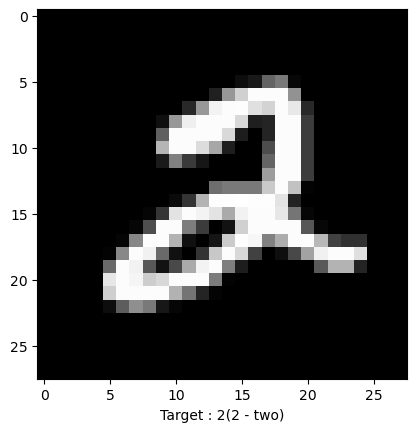

In [8]:
#(2) Display image
show_img(df=mnist_train, index=5)

In [9]:
#(3) Check `input_size`
input_shape = list(mnist_train[0][0].shape)

#(4) Print `input_size`
input_shape

[1, 28, 28]

In [10]:
#(5) Print frequency of target class
target_freq = collections.Counter()
for i in range(len(mnist_train)):
    input, target = mnist_train[i]
    if isinstance(target, torch.Tensor) :
        target = target.item()
    target_freq[target] += 1
pd.DataFrame(data=list(target_freq.items()), columns=['class', 'count']).sort_values(by='class')

,class,count
1,0,5923
3,1,6742
5,2,5958
6,3,6131
2,4,5842
0,5,5421
7,6,5918
8,7,6265
9,8,5851
4,9,5949


#### 01.4. **데이터로더 변환**

In [11]:
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 02. **모델 구축 및 학습**

#### 02.1. **하이퍼 파라미터 정의**

In [12]:
channel_cnt = 16

#### 02.1. **모델 정의**

In [13]:
#(1) Define `model`
model = MyConvAutoEncoder(input_shape=input_shape, channel_cnt=channel_cnt, class_num=10, device=device).to(dtype=torch.float32)

#(2) Display `model`
torchinfo.summary(
    model=model, 
    input_size=[BATCH_SIZE]+list(mnist_train[0][0].shape),
    device=device
)

Layer (type:depth-idx)                   Output Shape              Param #
MyConvAutoEncoder                        [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 16, 13, 13]          160
│    └─ReLU: 2-2                         [32, 16, 13, 13]          --
│    └─Conv2d: 2-3                       [32, 32, 6, 6]            4,640
│    └─ReLU: 2-4                         [32, 32, 6, 6]            --
│    └─Conv2d: 2-5                       [32, 64, 4, 4]            18,496
│    └─ReLU: 2-6                         [32, 64, 4, 4]            --
│    └─Flatten: 2-7                      [32, 1024]                --
│    └─Linear: 2-8                       [32, 10]                  10,250
│    └─ReLU: 2-9                         [32, 10]                  --
├─Sequential: 1-2                        [32, 1, 28, 28]           --
│    └─Linear: 2-10                      [32, 1024]                11,264

In [14]:
#(4) Define loss function
criterion = torch.nn.MSELoss()

#(5) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-7)

#(6) Define Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 02.2. **학습 전 변수 정의**

In [15]:
epoch = 0 
loss_hist = []
best_loss = float('inf')
if USE_PRETRAIN_YN == 'Y' :
    try :
        checkpoint = torch.load(f=MODEL_PTH, map_location=device)
        model.load_state_dict(state_dict=checkpoint['model'])
        optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
        epoch = checkpoint['epoch']
        loss_hist = checkpoint['loss_hist']
        best_loss = loss_hist[-1]
    except Exception :
        pass
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=0, Train Loss=inf


#### 02.3. **모델 학습**

In [16]:
batch_len = len(mnist_train_loader)
progress_bar = tqdm.trange(epoch+1, EPOCH_NUM+1)
training_log = {
    'epoch'  : [],
    'inputs' : [],
    'preds'  : []
}
for epoch in progress_bar : 
    last_loss = 0.0
    model.train()
    for batch_idx, (inputs, targets) in enumerate(iterable=mnist_train_loader) :
        optimizer.zero_grad() 
        preds = model(x=inputs)
        # ---- Not use `targets` ---- #
        loss = criterion(input=preds, target=inputs.to(device=device))
        # ---- _________________ ---- #
        loss.backward()
        optimizer.step()
        last_loss += loss.item()
        # ---- Logging ---- #
        if batch_idx == 0 : 
            training_log['epoch'].append(epoch)
            training_log['inputs'].append(inputs)
            training_log['preds'].append(preds)
        # ---- _______ ---- # 
    last_loss_avg = last_loss / batch_len
    loss_hist.append(last_loss_avg)
    if last_loss_avg < best_loss :
        best_epoch = epoch
        best_loss = last_loss_avg
        torch.save(
            obj={
                'model'      : model.state_dict(),
                'optimizer'  : optimizer.state_dict(),
                'best_epoch' : best_epoch,
                'loss_hist'  : loss_hist,
            }, 
            f=MODEL_PTH
        )
    # scheduler.step()
    progress_bar.set_postfix(ordered_dict={'last_epoch':epoch, 'last_loss':last_loss_avg, 'best_epoch':best_epoch, 'best_loss':best_loss})

100%|██████████| 10/10 [06:00<00:00, 36.07s/it, last_epoch=10, last_loss=0.0147, best_epoch=10, best_loss=0.0147]


<b></b>

## 03. **모델 평가**

#### 03.1. **최적 성능 모델 로드**

In [17]:
checkpoint = torch.load(f=MODEL_PTH, map_location=device)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Best Epoch : {np.argmin(a=checkpoint["loss_hist"])+1}, Best Loss : {np.min(a=checkpoint["loss_hist"])}')

>> Best Epoch : 10, Best Loss : 0.014724741162359714


#### 04.2. **과소 적합 확인**

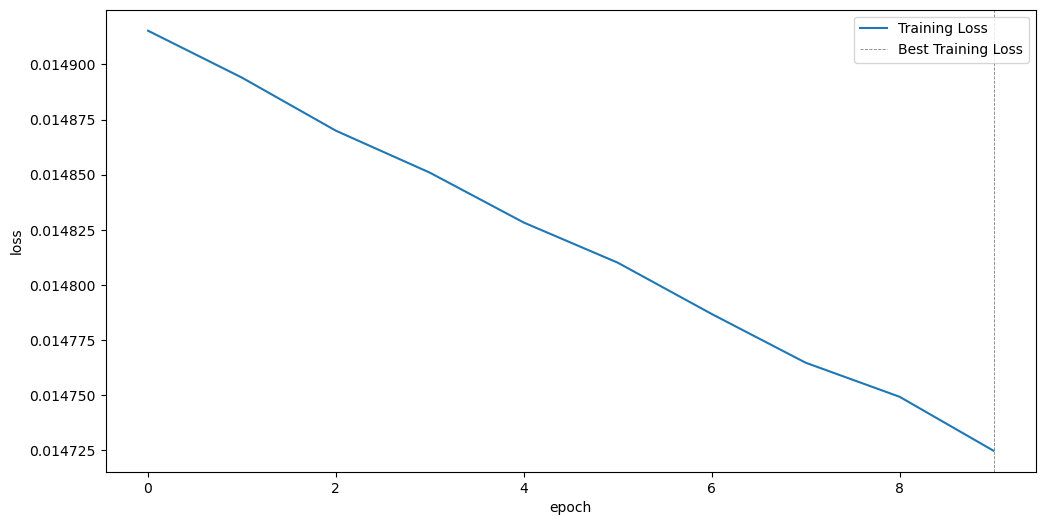

In [18]:
plt.figure(figsize=(12, 6))
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist, label='Training Loss')
plt.axvline(x=np.argmin(a=checkpoint["loss_hist"]), color='grey', linestyle='--', linewidth=0.6, label=f'Best Training Loss')
plt.legend(loc='upper right')
plt.show()

#### 03.3. **(에포크 별) 학습 과정 확인**

In [ ]:
draw_interactive_plot(training_log=training_log)